In [1]:
import tensorflow as tf
import librosa
from models.conv_autoencoder_2d import * 
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load style and content

In [2]:
CONTENT_FILENAME = "inputs/vctk_corpus/VCTK-Corpus/wav48/val/p300/p300_024.wav"
STYLE_FILENAME = "inputs/vctk_corpus/VCTK-Corpus/wav48/train/p228/p228_044.wav"

In [3]:
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))

In [4]:
# Reads wav file and produces spectrum
# Fourier phases are ignored
N_FFT = 2048
def read_audio_spectum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

In [5]:
a_content, fs = read_audio_spectum(CONTENT_FILENAME)
a_style, fs = read_audio_spectum(STYLE_FILENAME)

N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]
a_style = a_style[:N_CHANNELS, :N_SAMPLES]

### Visualize spectrograms for content and style tracks

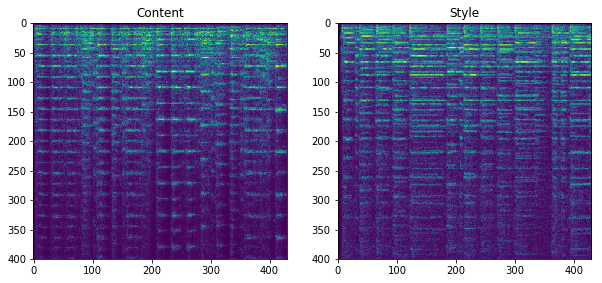

In [6]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.show()

### Compute content and style feats

In [42]:
input_batch_placeholder = tf.placeholder(tf.float32, shape=(2, N_SAMPLES, N_CHANNELS), name="input_batch")
ae_outputs, layer_features, loss = conv_ae_with_loss(input_batch_placeholder, training=False)
input_batch = np.array([a_style.T, a_content.T])

print("Model created")
    
sess = tf.Session()
print("Initializaing vars")
sess.run(tf.global_variables_initializer())
print("Starting loading")

saver = tf.train.Saver()
saver.restore(sess, "checkpoints/last_checkpoint/hyperspectral_resnet.model-519")

content_features = sess.run(layer_features[2], feed_dict={input_batch_placeholder:input_batch})[1, :, :]
style_features = sess.run(layer_features[0], feed_dict={input_batch_placeholder:input_batch})[0, :, :]

features = style_features # np.reshape(style_features, (-1, N_FILTERS))
style_gram = np.matmul(features.T, features) / N_SAMPLES

ValueError: Variable bn1/beta already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "/home/archa/code/archa/stanford/224s/audio-style-transfer/models/layers.py", line 109, in bn
    reuse=None)
  File "/home/archa/code/archa/stanford/224s/audio-style-transfer/models/autoencoder.py", line 14, in seq2seq_ae
    net = bn(input_batch, is_training, "bn1")
  File "/home/archa/code/archa/stanford/224s/audio-style-transfer/models/autoencoder.py", line 67, in seq2seq_ae_with_loss
    ae_output, layer_features = seq2seq_ae(input_batch, seq_lengths, training, seed=seed)


In [8]:
print(sess.run([tf.shape(ae_outputs)]))

[array([   2,  430, 1025], dtype=int32)]


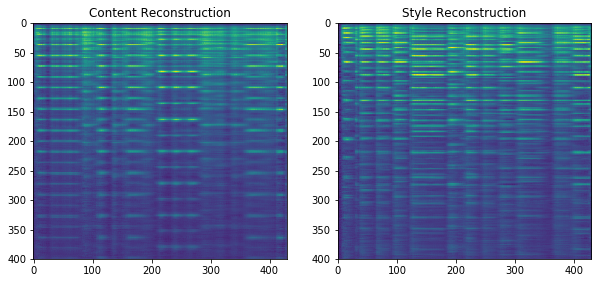

In [9]:
reconstruction = sess.run(ae_outputs, feed_dict={input_batch_placeholder:input_batch})
reconstruction = np.transpose(reconstruction, (0, 2, 1))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content Reconstruction')
plt.imshow(reconstruction[1, :400,:])
plt.subplot(1, 2, 2)
plt.title('Style Reconstruction')
plt.imshow(reconstruction[0, :400,:])
plt.show()

In [10]:
recon = np.zeros_like(a_content)
recon[:N_CHANNELS,:] = np.exp(reconstruction[1]) - 1 # np.exp(result[0,0].T) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(recon.shape) - np.pi
for i in range(500):
    S = recon * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))

OUTPUT_FILENAME = 'outputs/content_reconstruction.wav'
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)
print(OUTPUT_FILENAME)
display(Audio(OUTPUT_FILENAME))

outputs/content_reconstruction.wav


In [12]:
def count_number_trainable_params():
    '''
    Counts the number of trainable variables.
    '''
    tot_nb_params = 0
    for trainable_variable in tf.trainable_variables():
        shape = trainable_variable.get_shape() # e.g [D,F] or [W,H,C]
        current_nb_params = get_nb_params_shape(shape)
        tot_nb_params = tot_nb_params + current_nb_params
    return tot_nb_params

def get_nb_params_shape(shape):
    '''
    Computes the total number of params for a given shap.
    Works for any number of shapes etc [D,F] or [W,H,C] computes D*F and W*H*C.
    '''
    nb_params = 1
    for dim in shape:
        nb_params = nb_params*int(dim)
    return nb_params 


In [13]:
N_SAMPLES*N_CHANNELS

440750

### Optimize

In [40]:
from sys import stderr

ALPHA= 1e-2
learning_rate = 1000.0
iterations = 1000

result = None

with tf.variable_scope("input"):
    x = tf.Variable(np.random.randn(1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x")

with tf.variable_scope(tf.get_variable_scope(), reuse=True):
    _, layer_features, loss = seq2seq_ae_with_loss(x, seq_lengths= \
                                           tf.constant(np.array([N_SAMPLES])), training=False)

x_content_features = layer_features[2]
x_style_features = layer_features[0]

x_style_features = tf.squeeze(x_style_features, axis=[0])
x_style_gram = tf.matmul(tf.transpose(x_style_features), x_style_features)  / N_SAMPLES

content_loss = ALPHA * 2 * tf.nn.l2_loss(
        x_content_features - content_features)
style_loss = 2 * tf.nn.l2_loss(x_style_gram - style_gram)

 # Overall loss
style_transfer_loss = content_loss + style_loss

# TODO: Try different optimizers here - Adam is usually the best, so why not use Adam
opt = tf.train.AdamOptimizer(learning_rate)
q_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "input")
gradients, parameters = zip(*optimizer.compute_gradients(style_transfer_loss, var_list=q_vars))
train_op = optimizer.apply_gradients(zip(gradients, parameters))
        
# Optimization
sess = tf.Session()
sess.run(tf.global_variables_initializer())

print('Started optimization.')
for itr in range(iterations):
    _, loss = sess.run([train_op, style_transfer_loss])
        
print("final loss: {}".format(itr, loss))
result = x.eval(session=sess)

Started optimization.
final loss: 99999


### Invert spectrogram and save the result

In [41]:

a = np.zeros_like(a_content)
print(a)
a[:N_CHANNELS,:] = np.exp(result[0].T) - 1 # np.exp(result[0,0].T) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))

OUTPUT_FILENAME = 'outputs/out.wav'
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)
print(OUTPUT_FILENAME)
display(Audio(OUTPUT_FILENAME))

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
outputs/out.wav


### Visualize spectrograms

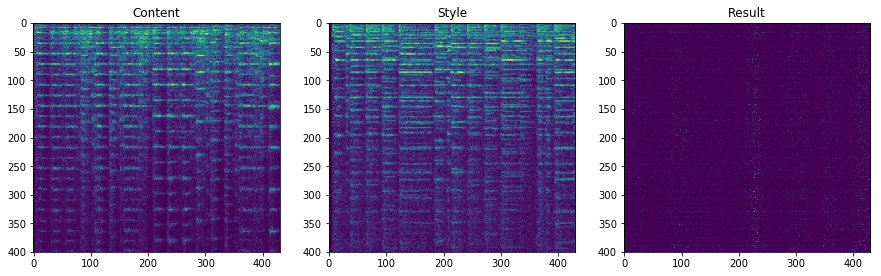

In [38]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1,3,2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.subplot(1,3,3)
plt.title('Result')
plt.imshow(a[:400,:])
plt.show()